#GPUs

nvidia-smi --query-compute-apps=pid --format=csv,noheader | xargs -I {} ps -p {} -o pid,cmd --no-headers


kill <PID>
kill -9 <PID>            (forces the kill)

In [1]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Bacis libraries #
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from datetime import datetime

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import * # added Losses for multiclassifier
from plotting import * #plot_roc, plot_confusion_matrix
from preprocess_binary_cache import *



torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")

Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:

import sys
import os

# Ensure the src directory is in your path
src_dir = os.path.abspath("../src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# Load cached/preprocessed dataset
data = get_preprocessed_dataset_binary(cache_path="cached_dataset_binary.pkl")
train_dataset      = data["train_dataset"]
valid_dataset      = data["valid_dataset"]
val_weight_nominal = data["val_weight_nominal"]
X = data["X"]
y = data["y"]
pad_mask           = data["pad_mask"]
event_level        = data["event_level"]
reweighting        = data["reweighting"]
weight_nominal_tensor = data["weight_nominal_tensor"]

train_X            = data["train_X"]
val_X              = data["val_X"]
train_y            = data["train_y"]
val_y              = data["val_y"]
train_weights      = data["train_weights"]
val_weights        = data["val_weights"]
train_mask         = data["train_mask"]
val_mask           = data["val_mask"]
train_event        = data["train_event"]
val_event          = data["val_event"]
train_weight_nominal = data["train_weight_nominal"]
outdir             = data["outdir"]
data_columns           = data["data_columns"]



# Create DataLoaders
batch_size = 1024
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=10,
)

valid_loader = DataLoader(
valid_dataset, 
batch_size=10000, 
shuffle=False,
num_workers = 10,
)



Loading preprocessed data from cache...


In [3]:
print(data_columns)

Index(['event', 'region', 'Generator_weight', 'Generator_scalePDF',
       'Generator_x1', 'Generator_x2', 'Generator_xpdf1', 'Generator_xpdf2',
       'cleanedJet_pt', 'cleanedJet_eta', 'cleanedJet_phi', 'cleanedJet_mass',
       'cleanedJet_area', 'cleanedJet_btagDeepFlavB', 'GenMET_pt',
       'GenMET_phi', 'InputMet_pt', 'InputMet_phi', 'ncleanedJet',
       'ncleanedBJet', 'HT', 'MHT_pt', 'MHT_phi', 'InputMet_InputJet_mindPhi',
       'weight_nominal', 'xs_weight', 'Pred', 'cleanedJet_pt_jesAbsolute_up',
       'cleanedJet_pt_jesAbsolute_down', 'cleanedJet_pt_jesBBEC1_up',
       'cleanedJet_pt_jesBBEC1_down', 'cleanedJet_pt_jesEC2_up',
       'cleanedJet_pt_jesEC2_down', 'cleanedJet_pt_jesFlavorQCD_up',
       'cleanedJet_pt_jesFlavorQCD_down', 'cleanedJet_pt_jesHF_up',
       'cleanedJet_pt_jesHF_down', 'cleanedJet_pt_jesRelativeBal_up',
       'cleanedJet_pt_jesRelativeBal_down',
       'cleanedJet_pt_jesAbsolute_2018_up',
       'cleanedJet_pt_jesAbsolute_2018_down', 'cleanedJ

### If Loading checkpoint, skip up to CheckpointCell

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$ #beam axis?
- var 2 : $\phi$ #beam axis? 
- var 3 : mass
- var 4 : area
- var 5 : btag #probability of whether the jet is a btag, assigned by separate algorithm


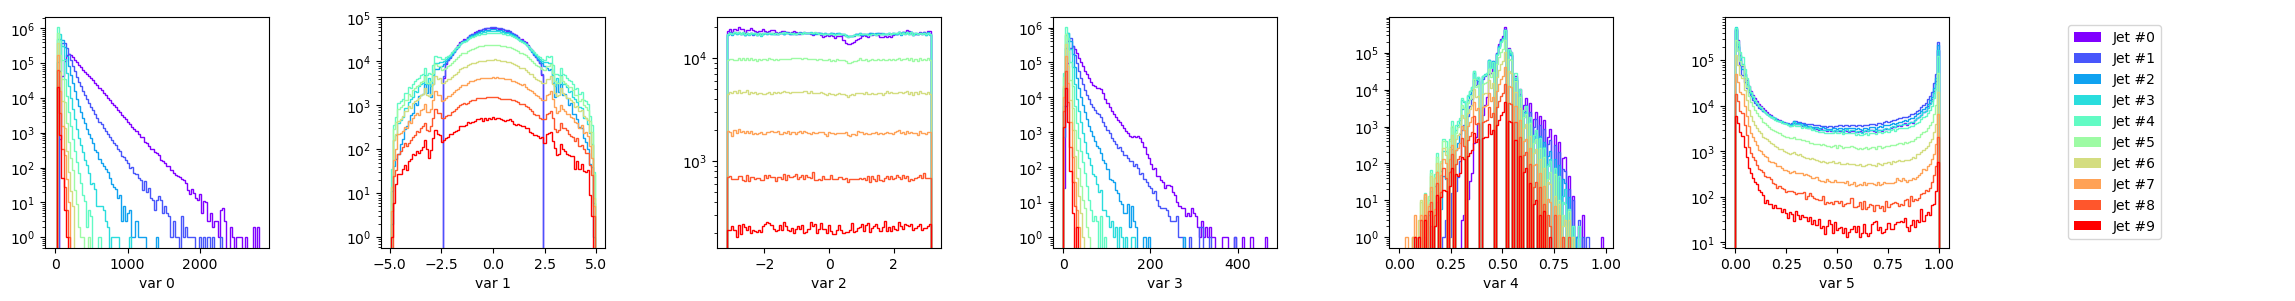

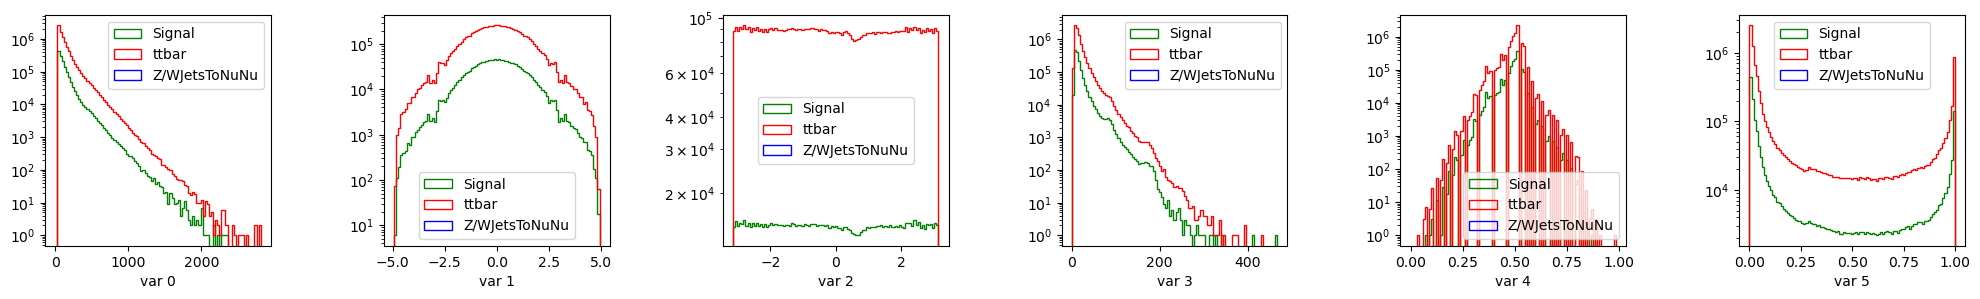

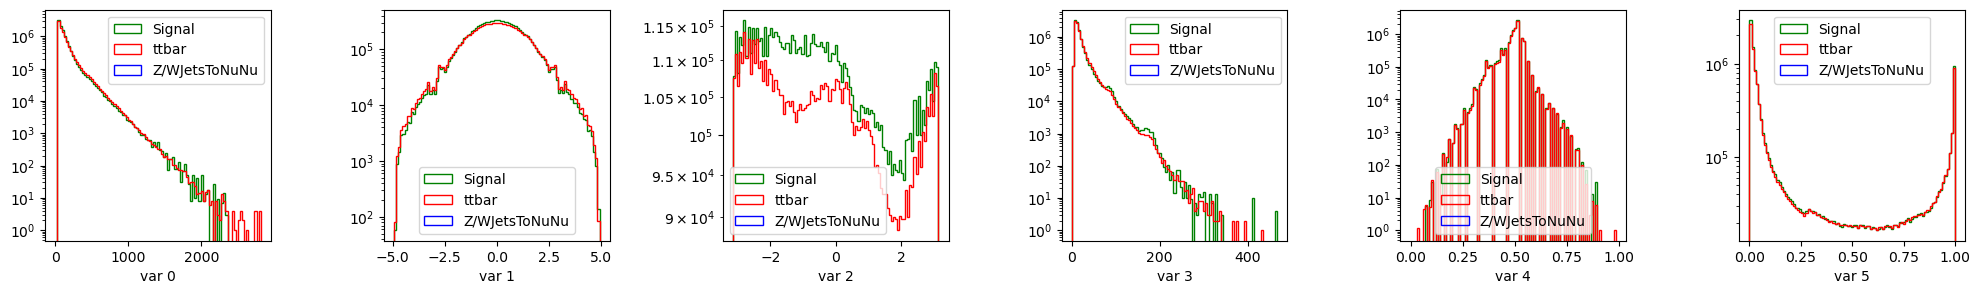

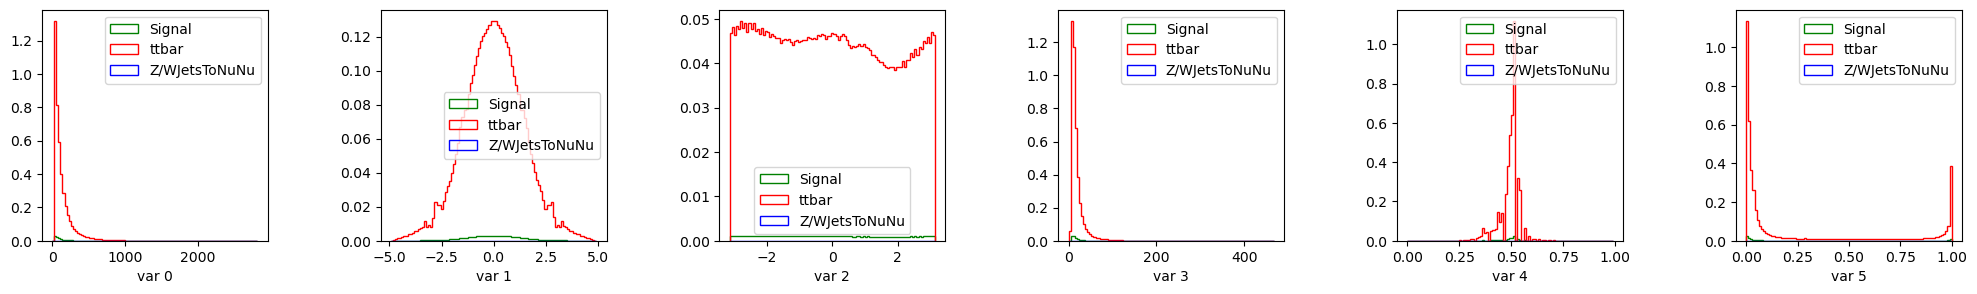

In [4]:
###MULTICLASSIFICATION###

fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, log=True, show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, weights=reweighting, log=True, show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, weights=weight_nominal_tensor, log=False, show=True)


# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [5]:
import torch.nn.functional as F

# Define model #

########
#MULTICLASSIFICATION: CrossEntropyLoss, FocalLoss?
########



#loss_function = BCEDecorrelatedLoss(lam = 0.1,weighted=True)
# loss = BCE + lambda * decorrelated loss 
# lambda = 0 -> pure BCE

#loss_function = MulticlassDecorrelatedLoss(lam=0.1, weighted=True) # This is CrossEntropyLoss with decorrelation loss
#loss_function = MulticlassDecorrelatedFocalLoss(gamma=0.5, alpha=None, lam=0.1, weighted=True) #gamma = 0 -> pure crossentropy

gamma = 0

loss_function = MulticlassFocalLoss(gamma=gamma, alpha=None, weighted=True)

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)


#LAYERS:
#Play around with the number of encoder layers, class layers and dnn layers.

encoder_layers = 5
class_layers = 3
dnn_layers = 3


model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim)
    output_dim = 3,                  # Output dimension (1 : binary classification, >1 : multi classification) - 4 for multiclass
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor) changed 4 to 2
    encoder_layers = encoder_layers,              # Number of encoder layers (self attention on jets), increased to 5
    class_layers = class_layers,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = dnn_layers,                  # Number of layers for DNN after the transformer (most of heavy lifting done by trnasformer, dont need >3)
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.1,                  # Dropout rate
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-4): 5 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks): M

Batch dtypes torch.float32 torch.float32 torch.float32 torch.bool torch.float32
outputs torch.Size([1024, 3])
losses tensor(2.0935, grad_fn=<MeanBackward0>)


# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [6]:
##### Parameters #####
epochs = 100 #was 500
lr = 1e-4

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.2, 
   patience = 4,               #reduce the learning rate after 4 (was 10) epochs without improvement
   threshold = 0.,              #threshold for measuring the new optimum
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,               #minimum learning rate
)

model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=4,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback_Multiclass(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback_Multiclass(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback_Multiclass(name='ROC'),
        ConfusionMatrixSubCallback_Multiclass(name='CM'),
    ]
)

## Logger ##
##Commented out for now to avoid large comet log files

logger = CometLogger(
    #api_key = os.getenv("COMET_API_KEY"),
    #api_key = "",
    project_name = "MSci-AnalysisObjectTransformer",
    experiment_name = f"3 BG, FL ({gamma}gamma): {lr}lr, {encoder_layers}enc, {class_layers}clas, {dnn_layers}dnn",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    #strategy = "ddp_notebook",  # Use distributed data parallel
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = 1,#[2,3,4], # Number of GPUs. Notebook only supports 1
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train,
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [
        checkpoint_callback, 
        early_stopping,
        log_bar,
        #plots_callback,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)

trainer.save_checkpoint(f"{outdir}/model.pt")

Training   : Batch size = 1024 => 1334 steps per epoch
Validation : Batch size = 10000 => 35 steps per epoch


CometLogger will be initialized in offline mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /users/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks/model_training/BinaryTransformer_20250312_200550 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | embedding      | Embedding           | 460    | train
1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved. New best score: 1.260


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.063 >= min_delta = 0.0. New best score: 1.197


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.036 >= min_delta = 0.0. New best score: 1.161


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.155


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 1.135


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 1.127


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.125


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.121


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.111


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.104


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.102


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.101


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/loss_tot did not improve in the last 4 records. Best score: 1.099. Signaling Trainer to stop.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 3 BG, FL (0gamma): 0.0001lr, 5enc, 3clas, 3dnn
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train/loss_tot [25] : (0.9757946729660034, 1.4296059608459473)
COMET INFO:     val/loss_tot [25]   : (1.0989947319030762, 1.2596111297607422)
COMET INFO:   Others:
COMET INFO:     Created from       : pytorch-lightning
COMET INFO:     Name               : 3 BG, FL (0gamma): 0.0001lr, 5enc, 3clas, 3dnn
COMET INFO:     offline_experiment : True


### Load Checkpoint Here, else skip

- Run everything from start, skipping trainer cell, then run the below cells.

In [4]:
import torch
import torch.nn as nn

# Path to your checkpoint
checkpoint_path = "./model_training/BinaryTransformer_20250312_200550/model.pt"

# Create the loss function that matches what was used during training
loss_function = MulticlassFocalLoss(gamma=0, alpha=None, weighted=True)

# Create the embedding with the CORRECT input dimension (important!)
# This must match the dimension used during original training
embedding = Embedding(
    input_dim = 6,  # Make sure this is the number of jet features used in training
    embed_dims = [64],
    normalize_input = True,
)

# Now load the checkpoint
print("Loading checkpoint from:", checkpoint_path)
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Print some checkpoint info to verify
print(f"Checkpoint keys: {list(checkpoint.keys())}")
if 'hyper_parameters' in checkpoint:
    print(f"Original parameters: {checkpoint['hyper_parameters']}")

# Create model with the same architecture as used in training
model = AnalysisObjectTransformer(
    embedding = embedding,
    embed_dim = embedding.dim,
    num_heads = 8,
    output_dim = 3,  # Number of classes (ttH, ttbar, Z/W+jets)
    expansion_factor = 4,
    encoder_layers = 5,
    class_layers = 3,
    dnn_layers = 3,
    hidden_activation = nn.GELU,
    output_activation = None,
    dropout = 0.1,
    loss_function = loss_function,
)

# Load the state dict
missing_keys = model.load_state_dict(checkpoint["state_dict"], strict=False)
print(f"Missing keys: {missing_keys}")

# Set model to evaluation mode
model.eval()
print("Model loaded successfully!")

Loading checkpoint from: ./model_training/BinaryTransformer_20250312_200550/model.pt
Checkpoint keys: ['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers']
Missing keys: <All keys matched successfully>
Model loaded successfully!


/tmp/ipykernel_3471628/3624267977.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cpu")


### continue

In [5]:
# ## Testing model performance on validation set ##




## Testing model performance on validation set ##
trainer = L.Trainer(accelerator=accelerator, devices=1)

preds = trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)


# Get data
inputs, labels, weights, mask, event = valid_dataset.tensors

probs = torch.softmax(preds, dim=1)  # Convert to probabilities

# Get predicted classes
pred_classes = torch.argmax(probs, dim=1)

# Calculate accuracy per class
for i in range(3):
    mask_i = labels == i
    acc_i = (pred_classes[mask_i] == labels[mask_i]).float().mean()
    print(f"Class {i} accuracy: {acc_i:.3f}")

# Overall accuracy
acc = (pred_classes == labels).float().mean()
print(f"\nOverall accuracy: {acc:.3f}")

print(f"\nPredictions shape: {preds.shape}")  # Should show 3 classes in second dimension

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


Predicting: |          | 0/? [00:00<?, ?it/s]

Class 0 accuracy: 0.702
Class 1 accuracy: 0.730
Class 2 accuracy: nan

Overall accuracy: 0.726

Predictions shape: torch.Size([341400, 3])


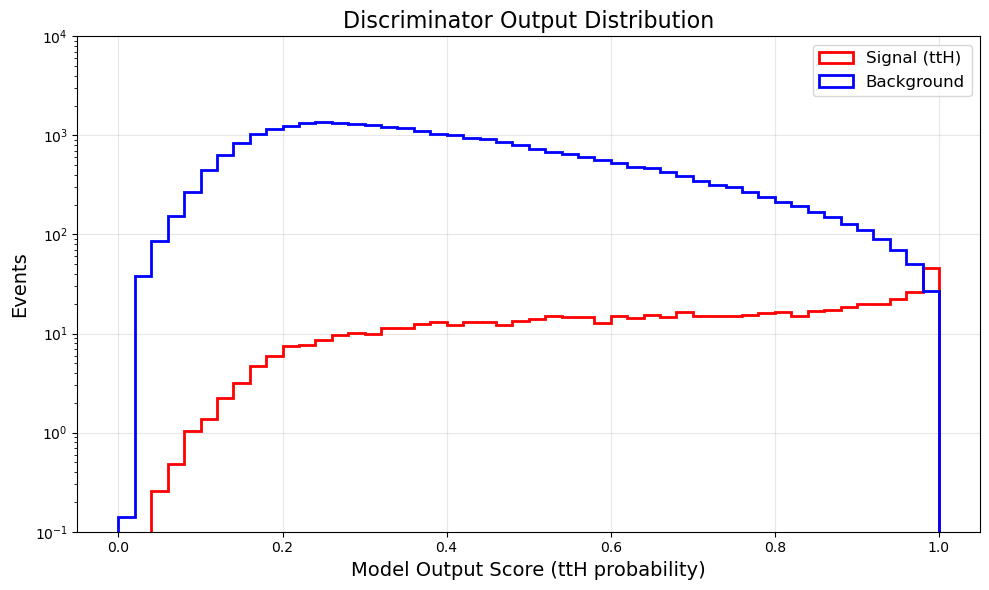

In [6]:
import numpy as np 
import matplotlib.pyplot as plt

# Get the model outputs and convert to numpy
probs_np = probs.detach().cpu().numpy()  # Convert probabilities to numpy
ttH_probs = probs_np[:, 0]  # Get probabilities for ttH class (signal)

# Get the labels and convert to numpy
labels_np = labels.detach().cpu().numpy().flatten()
binary_labels = (labels_np == 0).astype(int)  # Convert to binary (0=background, 1=signal)

# Get weights and scale them
weights_np = val_weight_nominal.detach().cpu().numpy().flatten() * 200000

# Create the plot
plt.figure(figsize=(10, 6))

# Plot signal histogram
plt.hist(ttH_probs[binary_labels == 1], 
         bins=50, 
         range=(0, 1),
         weights=weights_np[binary_labels == 1], 
         histtype='step', 
         linewidth=2,
         label='Signal (ttH)', 
         color='red')

# Plot background histogram
plt.hist(ttH_probs[binary_labels == 0], 
         bins=50, 
         range=(0, 1),
         weights=weights_np[binary_labels == 0], 
         histtype='step', 
         linewidth=2,
         label='Background', 
         color='blue')

# Add labels and styling
plt.xlabel('Model Output Score (ttH probability)', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.yscale('log')
plt.title('Discriminator Output Distribution', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.ylim(0.1, 1e4)
plt.show()

In [7]:
feature_checker = pd.read_parquet('/cephfs/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/ttH_HToInvisible_M125.parquet') 
print(feature_checker.columns)

Index(['event', 'region', 'Generator_weight', 'Generator_scalePDF',
       'Generator_x1', 'Generator_x2', 'Generator_xpdf1', 'Generator_xpdf2',
       'cleanedJet_pt', 'cleanedJet_eta', 'cleanedJet_phi', 'cleanedJet_mass',
       'cleanedJet_area', 'cleanedJet_btagDeepFlavB', 'GenMET_pt',
       'GenMET_phi', 'InputMet_pt', 'InputMet_phi', 'ncleanedJet',
       'ncleanedBJet', 'HT', 'MHT_pt', 'MHT_phi', 'InputMet_InputJet_mindPhi',
       'weight_nominal', 'xs_weight', 'Pred', 'cleanedJet_pt_jesAbsolute_up',
       'cleanedJet_pt_jesAbsolute_down', 'cleanedJet_pt_jesBBEC1_up',
       'cleanedJet_pt_jesBBEC1_down', 'cleanedJet_pt_jesEC2_up',
       'cleanedJet_pt_jesEC2_down', 'cleanedJet_pt_jesFlavorQCD_up',
       'cleanedJet_pt_jesFlavorQCD_down', 'cleanedJet_pt_jesHF_up',
       'cleanedJet_pt_jesHF_down', 'cleanedJet_pt_jesRelativeBal_up',
       'cleanedJet_pt_jesRelativeBal_down',
       'cleanedJet_pt_jesAbsolute_2018_up',
       'cleanedJet_pt_jesAbsolute_2018_down', 'cleanedJ

### ROC Curve

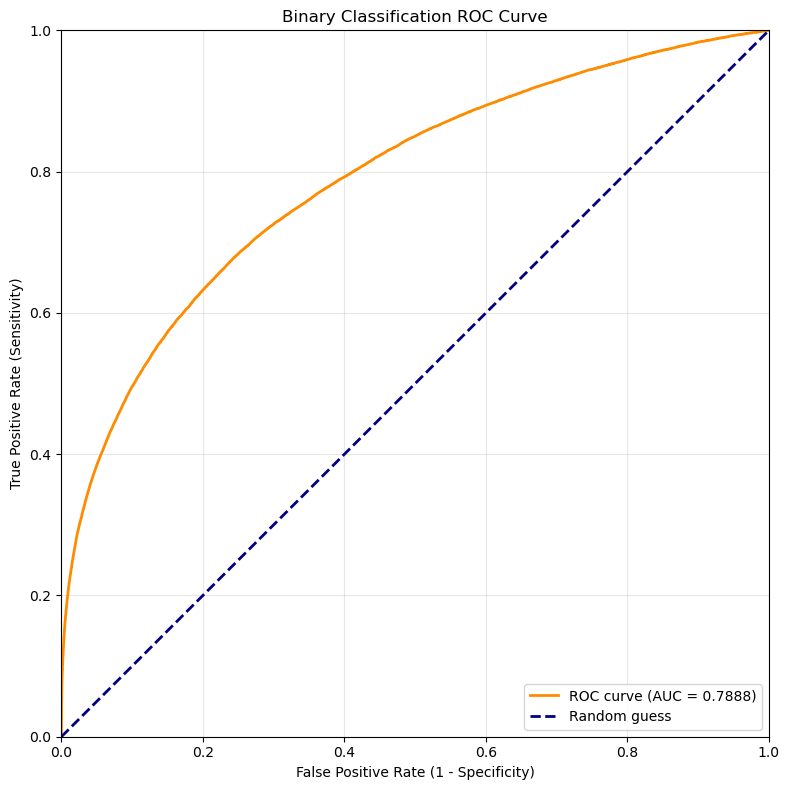

Area Under the ROC Curve (AUC): 0.79
Optimal threshold: 0.5266
At this threshold:
  - True Positive Rate (Sensitivity): 0.6725
  - False Positive Rate: 0.2381
  - Specificity: 0.7619


In [8]:
# Plot multiclass ROC curves
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import torch

# Ensure we're in evaluation mode
model.eval()

# Get predictions for validation set if not already done
if 'probs' not in locals() or 'labels' not in locals():
    with torch.no_grad():
        all_probs = []
        all_labels = []
        
        for inputs, labels, weights, mask, event in valid_loader:
            inputs = inputs.to(device)
            mask = mask.to(device)
            outputs = model(inputs, padding_mask=mask)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())
        
        probs = torch.cat(all_probs, dim=0)
        labels = torch.cat(all_labels, dim=0)

# Convert to numpy arrays for scikit-learn functions
probs_np = probs.numpy()
labels_np = labels.numpy()

# For binary classification, we need the probability of the signal class (class 0)
signal_probs = probs_np[:, 0]

# Convert labels to binary format (1 for signal, 0 for background)
# Since in your dataset, 0=signal and 1,2=background
binary_labels = (labels_np == 0).astype(int)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(binary_labels, signal_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Create ROC plot
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Binary Classification ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Add threshold markers
# Choose specific thresholds to mark
# markers_at = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
# for threshold in markers_at:
#     # Find the closest threshold value
#     idx = (np.abs(thresholds - threshold)).argmin()
#     plt.plot(fpr[idx], tpr[idx], 'o', markersize=6, 
#              label=f'Threshold = {threshold:.2f}')

plt.legend(loc="lower right")
plt.tight_layout()

# Save if outdir is defined
if 'outdir' in locals() and outdir:
    plt.savefig(f"{outdir}/binary_roc_curve.pdf")
    plt.savefig(f"{outdir}/binary_roc_curve.png", dpi=300)

plt.show()

# Print some statistics
print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")

# Find optimal threshold based on maximum Youden's J statistic (Sensitivity + Specificity - 1)
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"  - True Positive Rate (Sensitivity): {tpr[optimal_idx]:.4f}")
print(f"  - False Positive Rate: {fpr[optimal_idx]:.4f}")
print(f"  - Specificity: {1-fpr[optimal_idx]:.4f}")

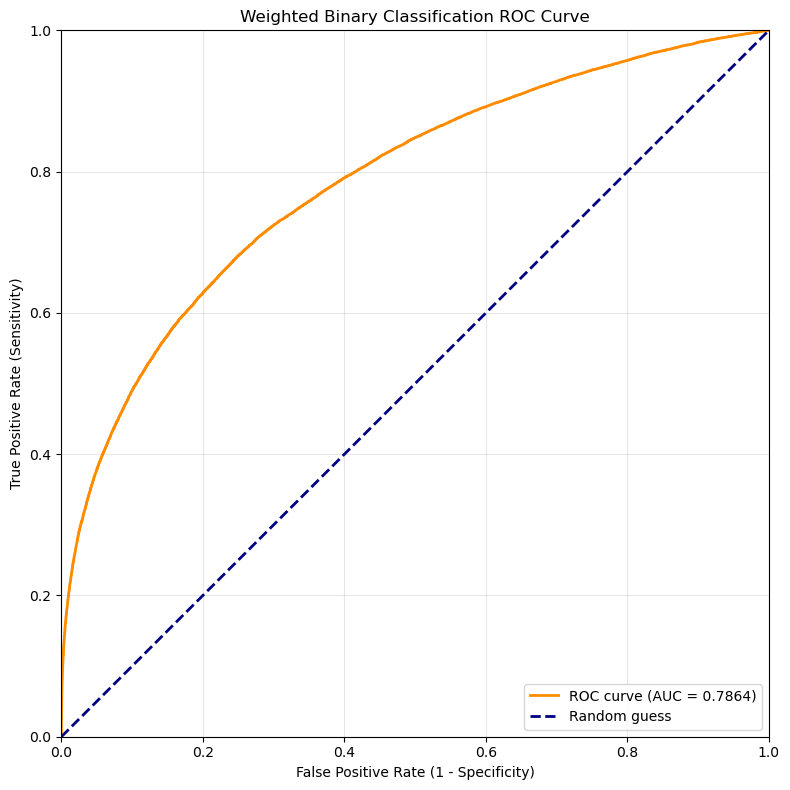

Area Under the ROC Curve (AUC): 0.79
Optimal threshold: 0.5222
At this threshold:
  - True Positive Rate (Sensitivity): 0.6798
  - False Positive Rate: 0.2484
  - Specificity: 0.7516


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

# Ensure we're in evaluation mode
model.eval()

# Get predictions for validation set (including sample weights)
if 'probs' not in locals() or 'labels' not in locals() or 'weights' not in locals():
    with torch.no_grad():
        all_probs = []
        all_labels = []
        all_weights = []
        
        for inputs, labels_batch, weights_batch, mask, event in valid_loader:
            inputs = inputs.to(device)
            mask = mask.to(device)
            outputs = model(inputs, padding_mask=mask)
            probs_batch = torch.softmax(outputs, dim=1)
            
            all_probs.append(probs_batch.cpu())
            all_labels.append(labels_batch.cpu())
            all_weights.append(weights_batch.cpu())
        
        probs = torch.cat(all_probs, dim=0)
        labels = torch.cat(all_labels, dim=0)
        weights = torch.cat(all_weights, dim=0)

# Convert tensors to numpy arrays
probs_np = probs.numpy()
labels_np = labels.numpy()
weights_np = weights.numpy()

# For binary classification, use the probability of the signal class (class 0)
signal_probs = probs_np[:, 0]

# Convert labels to binary format: 1 for signal, 0 for background 
# (assuming in your dataset 0=signal, and 1,2=background)
binary_labels = (labels_np == 0).astype(int)

# Calculate ROC curve using sample weights
fpr, tpr, thresholds = roc_curve(binary_labels, signal_probs, sample_weight=weights_np)

# Calculate AUC based on the weighted ROC curve
roc_auc = auc(fpr, tpr)

# Create ROC plot
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Weighted Binary Classification ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()

# Save the figure if outdir is defined
if 'outdir' in locals() and outdir:
    plt.savefig(f"{outdir}/binary_weighted_roc_curve.pdf")
    plt.savefig(f"{outdir}/binary_weighted_roc_curve.png", dpi=300)

plt.show()

# Print some statistics
print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")

# Find optimal threshold based on maximum Youden's J statistic (Sensitivity + Specificity - 1)
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")
print("At this threshold:")
print(f"  - True Positive Rate (Sensitivity): {tpr[optimal_idx]:.4f}")
print(f"  - False Positive Rate: {fpr[optimal_idx]:.4f}")
print(f"  - Specificity: {1 - fpr[optimal_idx]:.4f}")

In [9]:
np.savez('roc_data_TransformerBinary.npz', 
         fpr=fpr, 
         tpr=tpr, 
         auc=roc_auc)

In [12]:
pwd

'/users/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks'

# Plotting Significance (Z-Score) 


No systematic:
Max significance: 8.88
At threshold: 0.980
S: 46.1
B: 27.0

5% systematic:
Max significance: 8.59
At threshold: 0.980
S: 46.1
B: 27.0

10% systematic:
Max significance: 7.87
At threshold: 0.980
S: 46.1
B: 27.0


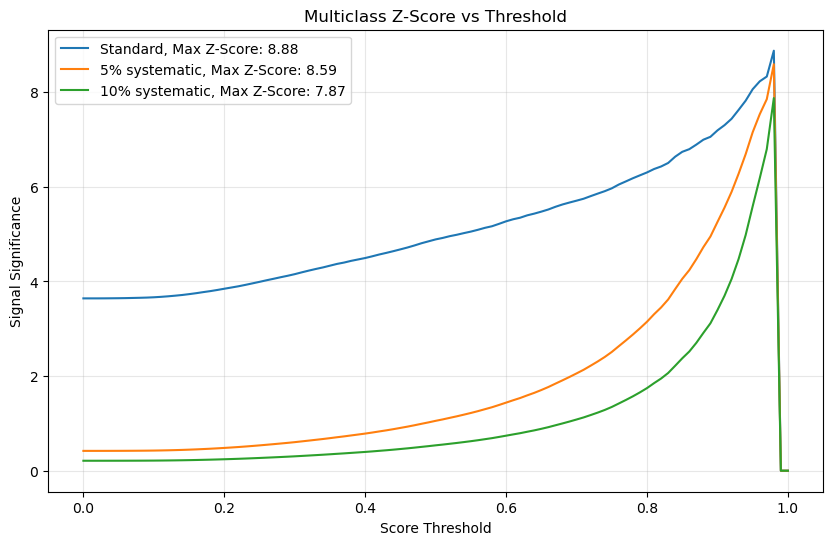

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Convert model outputs to probabilities for each class using softmax (preds.shape => [N, 3])


# Assuming preds[:, 0] corresponds to signal probability
pred_probs = torch.softmax(preds, dim=1).detach().cpu().numpy()  # shape (N,3)

# For Z-score calculation, use probability of signal (class=0)
signal_scores = pred_probs[:, 0].flatten()


# Ground truth: 0 => signal, 1 or 2 => background
truth = labels.detach().cpu().numpy().flatten()

# Weigh events (example: multiply nominal weights by 2e5 for convenience)
#event_weights_np = val_weight_nominal.clone().detach().cpu().numpy().flatten() * 200000
event_weights_np = np.array((val_weight_nominal *200000).flatten())

# Prepare thresholds
thresh_points = np.linspace(0, 1, 101)
significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Events passing threshold
    signal_mask = (signal_scores > cut) & (truth == 0)
    bkg_mask = (signal_scores > cut) & (truth != 0)
    
    # Weighted S and B
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    

    
    if S >=10  and B >=10:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.10 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance & thresholds
max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print info at these thresholds
for thresh_val, sig, label in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    signal_mask = (signal_scores > thresh_val) & (truth == 0)
    bkg_mask = (signal_scores > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    print(f"\n{label}:")
    print(f"Max significance: {sig:.2f}")
    print(f"At threshold: {thresh_val:.3f}")
    print(f"S: {S:.1f}")
    print(f"B: {B:.1f}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresh_points, significance_0, label=f'Standard, Max Z-Score: {max_0:.2f}')
plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z-Score: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic, Max Z-Score: {max_10:.2f}')

plt.xlabel('Score Threshold')
plt.ylabel('Signal Significance')
plt.title('Multiclass Z-Score vs Threshold')
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()


No systematic:
Max significance: 8.88
At threshold: 0.980
S: 46.1
B: 27.0

5% systematic:
Max significance: 8.59
At threshold: 0.980
S: 46.1
B: 27.0

10% systematic:
Max significance: 8.59
At threshold: 0.980
S: 46.1
B: 27.0


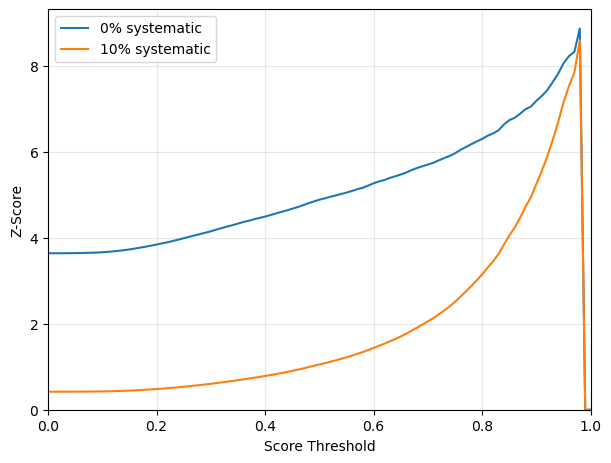

In [25]:
# Prepare thresholds
thresh_points = np.linspace(0, 1, 101)
significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Events passing threshold
    signal_mask = (signal_scores > cut) & (truth == 0)
    bkg_mask = (signal_scores > cut) & (truth != 0)
    
    # Weighted S and B
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    if S >=10  and B >=10:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.05 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance & thresholds
max_0 = np.max(significance_0)
#max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
#idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
#thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print info at these thresholds
for thresh_val, sig, label in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    signal_mask = (signal_scores > thresh_val) & (truth == 0)
    bkg_mask = (signal_scores > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    print(f"\n{label}:")
    print(f"Max significance: {sig:.2f}")
    print(f"At threshold: {thresh_val:.3f}")
    print(f"S: {S:.1f}")
    print(f"B: {B:.1f}")

# Plot
plt.figure(figsize=(7,5.2))
plt.plot(thresh_points, significance_0, label=f'0% systematic')
#plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z-Score: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic')

plt.xlabel('Score Threshold')
plt.ylabel('Z-Score')
#plt.title('Multiclass Z-Score vs Threshold')
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.xlim(0, 1)  # Set x-axis limits to 0 and 1
plt.ylim(bottom=0)  # Set y-axis limits to 0
plt.show()

In [ ]:
# import numpy as np 
# import matplotlib.pyplot as plt

# # Get the validation tensors from valid_dataset:
# # (Assumes valid_dataset was created via train_test_split)
# #val_inputs, val_labels, val_weights, val_mask, val_events = valid_dataset.tensors
# val_labels = valid_dataset.tensors[1]

# # Convert validation labels and weights to numpy
# labels_np = val_labels.detach().cpu().numpy().flatten()              # Now shape should match predictions
# weights_np = val_weight_nominal.detach().cpu().numpy().flatten()       # Adjust if needed, should match labels_np

# # Convert predictions (probs) to numpy (they come from trainer.predict on valid_loader)
# probs_np = probs.detach().cpu().numpy()  # shape (N, num_classes)

# # Extract only the ttH column (class 0)
# ttH_probs = probs_np[:, 0]

# # Create binary labels: 1 for signal (ttH, when original label==0), 0 for background (label>0)
# binary_labels = np.where(labels_np == 0, 1, 0)

# # Create a figure with two subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)

# # ---------------------------
# # First plot: Binary classification (normalized)
# axes[0].hist(ttH_probs[binary_labels == 1], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[binary_labels == 1],
#              histtype='step', label='Signal')
# axes[0].hist(ttH_probs[binary_labels == 0], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[binary_labels == 0],
#              histtype='step', label='Background')
# axes[0].legend()
# axes[0].set_ylabel('Events')
# axes[0].set_yscale('log')
# axes[0].set_title('')
# axes[0].set_ylim(1, 1e4)

# plt.tight_layout()
# plt.show()

In [12]:
# probs_flat = np.array(signal_scores)
# binary_labels = truth
# labels_flat = labels.flatten()
# wn = event_weights_np.flatten()
# # Create a figure with two subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)

# # First plot (Binary classification: Signal vs. Background)
# axes[0].hist(probs_flat[binary_labels == 1], bins=50, range=(0, 1), weights=wn[binary_labels == 1], histtype='step', label='Signal')
# axes[0].hist(probs_flat[binary_labels == 0], bins=50, range=(0, 1), weights=wn[binary_labels == 0], histtype='step', label='Background')
# axes[0].legend()
# axes[0].set_ylabel('Events')
# axes[0].set_xlabel('Prediction')
# axes[0].set_yscale('log')
# axes[0].set_title('Signal vs Background (logscale)')


# # Show the figure
# plt.tight_layout()
# plt.show()

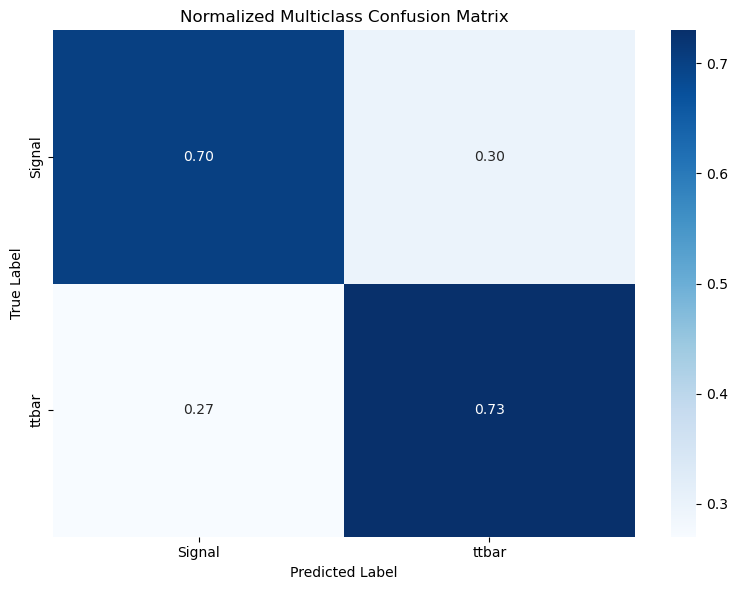

In [13]:
# # filepath: /home/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks/training_multiclassification.ipynb

import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# After training, switch model to eval mode
model.eval()

all_preds = []
all_labels = []

# Gather predictions and labels from validation set
with torch.no_grad():
    for inputs, labels, weights, mask, event in valid_loader:
        outputs = model(inputs, padding_mask=mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Define class labels
class_names = ['Signal', 'ttbar']

# Generate normalized confusion matrix
cf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1], normalize='true')

plt.figure(figsize=(8,6))  # Increased figure size for 4x4 matrix
sns.heatmap(cf_matrix, 
            annot=True, 
            cmap='Blues', 
            fmt='.2f',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Multiclass Confusion Matrix')
plt.tight_layout()
plt.show()

### Distributions of Predictions

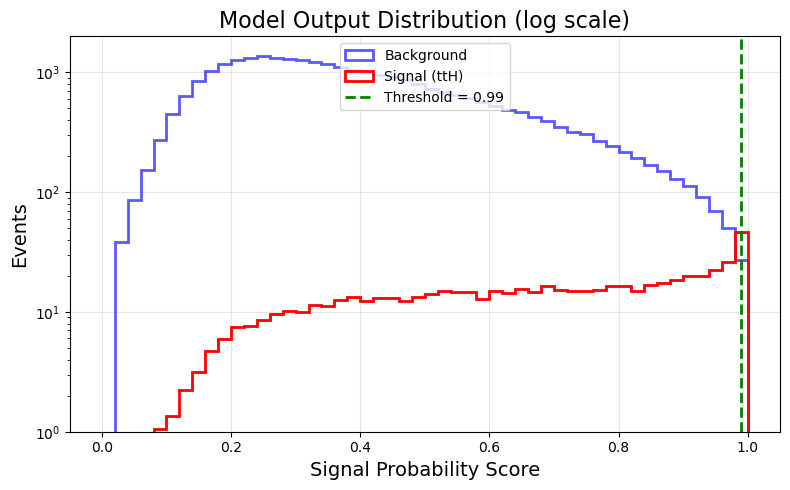

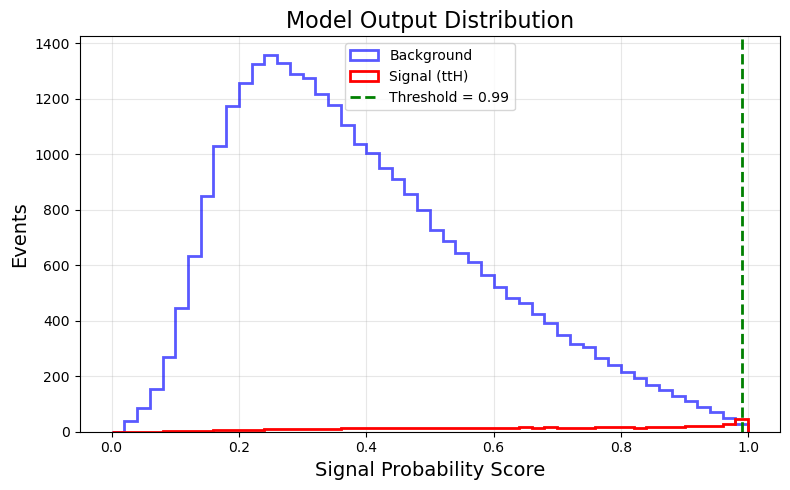

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

# Get predictions for all validation data
all_outputs = []
all_labels = []
all_weights = []

# Use the validation loader
with torch.no_grad():
    for inputs, labels, weights, mask, event in valid_loader:
        # Get model outputs
        outputs = model(inputs, padding_mask=mask)
        
        # Apply softmax to get probabilities
        probs_batch = torch.softmax(outputs, dim=1)
        
        # Store signal probabilities (class 0), labels, and weights
        all_outputs.extend(probs_batch[:, 0].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_weights.extend(weights.cpu().numpy())

# Convert to numpy arrays for easier manipulation
all_outputs = np.array(all_outputs)
all_labels = np.array(all_labels)
all_weights = np.array(val_weight_nominal.cpu()) * 200000  # Scale weights

# Find the best threshold (you can replace this with your preferred value)
best_threshold = 0.99

# Create log-scale plot
plt.figure(figsize=(8, 5))

# Background (all_labels != 0)
plt.hist(all_outputs[all_labels != 0], 
         bins=50, 
         range=(0, 1),
         alpha=0.65, 
         label='Background', 
         weights=all_weights[all_labels != 0], 
         color='b',
         log=True,
         histtype='step',
         linewidth=2)

# Signal (all_labels == 0)
plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1), 
         label='Signal (ttH)',  
         weights=all_weights[all_labels == 0], 
         color='r', 
         alpha=1.0,
         log=True,
         histtype='step',
         linewidth=2)

plt.ylim(1,10**(3.3))


plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, 
           label=f'Threshold = {best_threshold:.2f}')
plt.xlabel('Signal Probability Score', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Model Output Distribution (log scale)', fontsize=16)
plt.legend(loc='upper center')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Create linear-scale plot
plt.figure(figsize=(8, 5))

# Background (all_labels != 0)
plt.hist(all_outputs[all_labels != 0], 
         bins=50, 
         range=(0, 1),
         alpha=0.65, 
         label='Background', 
         weights=all_weights[all_labels != 0], 
         color='b',
         histtype='step',
         linewidth=2)

# Signal (all_labels == 0)
plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1), 
         label='Signal (ttH)',  
         weights=all_weights[all_labels == 0], 
         color='r', 
         alpha=1.0,
         histtype='step',
         linewidth=2)



plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, 
           label=f'Threshold = {best_threshold:.2f}')
plt.xlabel('Signal Probability Score', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Model Output Distribution', fontsize=16)
plt.legend(loc='upper center')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Confusion Matrix Fixed

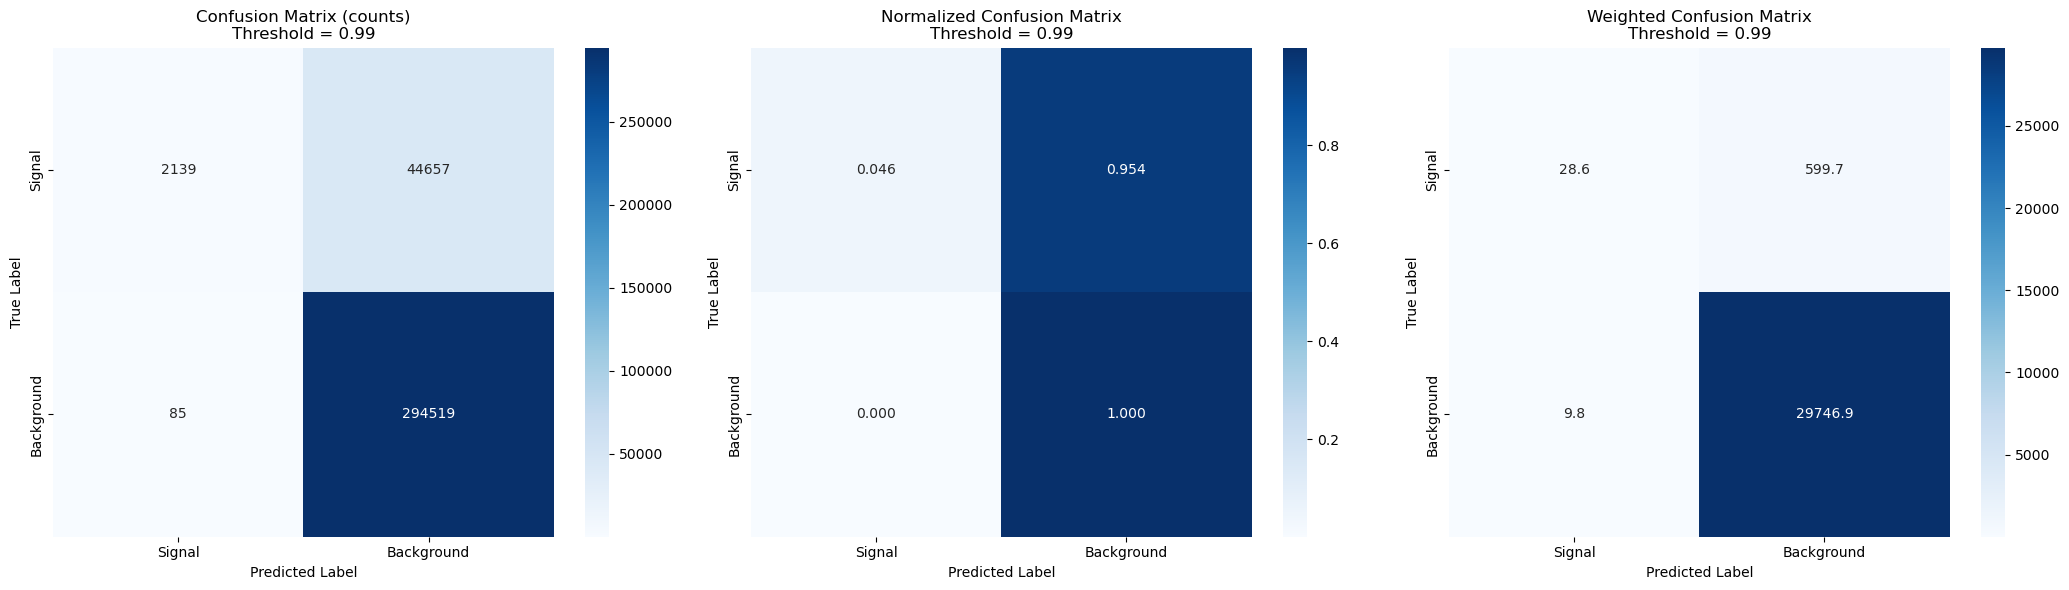

Classification Metrics (threshold = 0.99):
Accuracy: 0.8689
Precision: 0.9618
Recall: 0.0457
F1 Score: 0.0873
Specificity: 0.9997


In [17]:
import numpy as np
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Use the best threshold
best_threshold = 0.99

# Get predictions and true labels
with torch.no_grad():
    # Process validation data with model
    all_outputs = []
    all_labels = []
    all_weights = []
    
    for inputs, labels, weights, mask, event in valid_loader:
        outputs = model(inputs, padding_mask=mask)
        probs = torch.softmax(outputs, dim=1)
        all_outputs.extend(probs[:, 0].cpu().numpy())  # Signal class probability
        all_labels.extend(labels.cpu().numpy())
        all_weights.extend(weights.cpu().numpy())

# Convert to numpy arrays
all_outputs = np.array(all_outputs)
all_labels = np.array(all_labels)
all_weights = np.array(val_weight_nominal.cpu()) * 200000  # Scale weights for visibility

# Binary prediction based on threshold
binary_preds = (all_outputs > best_threshold).astype(int)

# Convert labels to binary (0=signal, rest=background)
# Note: In this dataset, 0=signal, 1/2=background
binary_labels = (all_labels == 0).astype(int)

# Create confusion matrix (standard order initially)
cm = confusion_matrix(binary_labels, binary_preds)

# Calculate metrics (before reordering)
accuracy = accuracy_score(binary_labels, binary_preds)
precision = precision_score(binary_labels, binary_preds, zero_division=0)
recall = recall_score(binary_labels, binary_preds)
f1 = f1_score(binary_labels, binary_preds)

# Reorder the confusion matrix
# Since you want Signal on top (y-axis) and left (x-axis),
# and binary_labels/binary_preds are 1=Signal, 0=Background,
# we need to reverse both rows and columns
reordered_cm = cm[::-1, ::-1]  # Reverse both rows and columns

# Create normalized confusion matrix (by row)
normalized_cm = np.zeros((2, 2))
for i in range(2):
    row_sum = reordered_cm[i, :].sum()
    if row_sum > 0:
        normalized_cm[i, :] = reordered_cm[i, :] / row_sum

# Create weighted confusion matrix 
weighted_cm = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        mask = (binary_labels == i) & (binary_preds == j)
        weighted_cm[i, j] = np.sum(all_weights[mask])

# Reorder weighted confusion matrix the same way
reordered_weighted_cm = weighted_cm[::-1, ::-1]  # Reverse both rows and columns

# Plot all three confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# 1. Standard counts confusion matrix - only showing the counts
sns.heatmap(reordered_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Signal', 'Background'],
            yticklabels=['Signal', 'Background'], ax=axes[0])
axes[0].set_title(f'Confusion Matrix (counts)\nThreshold = {best_threshold:.2f}')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# 2. Normalized confusion matrix - showing decimal values
sns.heatmap(normalized_cm, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=['Signal', 'Background'],
            yticklabels=['Signal', 'Background'], ax=axes[1])
axes[1].set_title(f'Normalized Confusion Matrix\nThreshold = {best_threshold:.2f}')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# 3. Weighted confusion matrix - showing weighted values
sns.heatmap(reordered_weighted_cm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Signal', 'Background'],
            yticklabels=['Signal', 'Background'], ax=axes[2])
axes[2].set_title(f'Weighted Confusion Matrix\nThreshold = {best_threshold:.2f}')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print metrics
print(f"Classification Metrics (threshold = {best_threshold:.2f}):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {cm[0,0]/(cm[0,0]+cm[0,1]):.4f}")

# Redoing plots

In [26]:


# Plot 1: Normalized by row (shows classification rate)
plt.figure(figsize=(8, 6))
conf_norm_row = reordered_cm.astype('float') / reordered_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_norm_row, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Signal', 'Background'],
            yticklabels=['Signal', 'Background'], 
            cbar=False)  # Remove colorbar
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 2: Normalized by column (shows precision)
plt.figure(figsize=(8, 6))
conf_norm_col = reordered_cm.astype('float') / reordered_cm.sum(axis=0)[np.newaxis, :]
sns.heatmap(conf_norm_col, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Signal', 'Background'],
            yticklabels=['Signal', 'Background'], 
            cbar=False)  # Remove colorbar
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# Print metrics
print(f"Classification Metrics (threshold = {best_threshold:.2f}):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

NameError: name 'reordered_cm' is not defined

#### Z-Score:


No systematic:
Max significance: 8.88
At threshold: 0.980
S: 46.1
B: 27.0

5% systematic:
Max significance: 8.59
At threshold: 0.980
S: 46.1
B: 27.0

10% systematic:
Max significance: 7.87
At threshold: 0.980
S: 46.1
B: 27.0


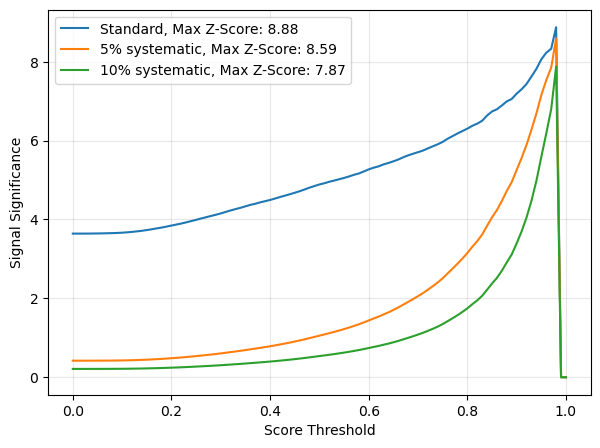

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Convert model outputs to probabilities for each class using softmax (preds.shape => [N, 3])


# Prepare thresholds
thresh_points = np.linspace(0, 1, 101)
significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Events passing threshold
    signal_mask = (signal_scores > cut) & (truth == 0)
    bkg_mask = (signal_scores > cut) & (truth != 0)
    
    # Weighted S and B
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    

    
    if S >=10  and B >=10:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.10 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance & thresholds
max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print info at these thresholds
for thresh_val, sig, label in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    signal_mask = (signal_scores > thresh_val) & (truth == 0)
    bkg_mask = (signal_scores > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    print(f"\n{label}:")
    print(f"Max significance: {sig:.2f}")
    print(f"At threshold: {thresh_val:.3f}")
    print(f"S: {S:.1f}")
    print(f"B: {B:.1f}")

# Plot
plt.figure(figsize=(7,5))
plt.plot(thresh_points, significance_0, label=f'Standard, Max Z-Score: {max_0:.2f}')
plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z-Score: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic, Max Z-Score: {max_10:.2f}')

plt.xlabel('Score Threshold')
plt.ylabel('Signal Significance')
#plt.title('Multiclass Z-Score vs Threshold')
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()

In [18]:
feature_checker = pd.read_parquet('/cephfs/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/ttH_HToInvisible_M125.parquet') 
print(feature_checker.columns)

Index(['event', 'region', 'Generator_weight', 'Generator_scalePDF',
       'Generator_x1', 'Generator_x2', 'Generator_xpdf1', 'Generator_xpdf2',
       'cleanedJet_pt', 'cleanedJet_eta', 'cleanedJet_phi', 'cleanedJet_mass',
       'cleanedJet_area', 'cleanedJet_btagDeepFlavB', 'GenMET_pt',
       'GenMET_phi', 'InputMet_pt', 'InputMet_phi', 'ncleanedJet',
       'ncleanedBJet', 'HT', 'MHT_pt', 'MHT_phi', 'InputMet_InputJet_mindPhi',
       'weight_nominal', 'xs_weight', 'Pred', 'cleanedJet_pt_jesAbsolute_up',
       'cleanedJet_pt_jesAbsolute_down', 'cleanedJet_pt_jesBBEC1_up',
       'cleanedJet_pt_jesBBEC1_down', 'cleanedJet_pt_jesEC2_up',
       'cleanedJet_pt_jesEC2_down', 'cleanedJet_pt_jesFlavorQCD_up',
       'cleanedJet_pt_jesFlavorQCD_down', 'cleanedJet_pt_jesHF_up',
       'cleanedJet_pt_jesHF_down', 'cleanedJet_pt_jesRelativeBal_up',
       'cleanedJet_pt_jesRelativeBal_down',
       'cleanedJet_pt_jesAbsolute_2018_up',
       'cleanedJet_pt_jesAbsolute_2018_down', 'cleanedJ